In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pipeline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
data = sns.load_dataset("tips")

In [4]:
y = data['tip']

X = data.drop(columns=['tip'])

In [5]:
X_train_3,X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.3, random_state=60)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [7]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

In [8]:
cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

In [9]:
from sklearn.compose import ColumnTransformer

In [10]:
preprocessor = ColumnTransformer([
    ('num_transformer', num_pipeline, ["size","total_bill"]),
    ('cat_transformer', cat_transformer, ["sex","smoker","day","time"])
])

In [11]:
from sklearn.pipeline import make_pipeline


In [12]:
from sklearn import set_config
set_config(display="diagram")

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
pipeline_workflow = make_pipeline(preprocessor, LinearRegression())

In [15]:
pipeline_workflow

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['size', 'total_bill']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('linearregression', LinearRegression())])

In [16]:
from sklearn.linear_model import Ridge

In [17]:
pipeline_workflow_ridge = make_pipeline(preprocessor, Ridge())

In [18]:
pipeline_workflow_ridge

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['size', 'total_bill']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('ridge', Ridge())])

In [19]:
pipeline_workflow.fit(X_train_3,y_train_3)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['size', 'total_bill']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('linearregression', LinearRegression())])

In [20]:
pipeline_workflow.score(X_test_3, y_test_3)

0.3484015613334338

In [21]:
y_pred = pipeline_workflow.predict(X_test_3)

In [22]:
import pickle

pickle.dump(pipeline_workflow, open('pipline.pkl', 'wb'))

In [23]:
pickled_model = pickle.load(open('pipline.pkl', 'rb'))

In [24]:
pickled_model.score(X_test_3, y_test_3)

0.3484015613334338

In [25]:
from sklearn.model_selection import cross_val_score

# Cross-validate Pipeline
cross_val_score(pipeline_workflow, X_train_3, y_train_3, cv=5, scoring='r2').mean()

0.3660585021016723

In [26]:
residus = y_pred - y_test_3

In [27]:
def remove_spine(axe):
    axe.spines.right.set_visible(False)
    axe.spines.top.set_visible(False)

In [28]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

def test_homo():
    names = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
    test = sms.het_breuschpagan(residus, preprocessor.fit_transform(X_test_3))
    p_value = lzip(names, test)[1][1]
    if p_value > 0.5:
        interprete = f"p-value = {p_value} > 0.5: Nous ne pouvons pas rejeter l'hyptohese nulle sur l'homoscedasticité. C'est homoscedasticité"
    else:
        interprete = f"p-value = {p_value} < 0.5: Nous pouvons rejeter l'hyptohese nulle. C'est hétéroscadastique"

    interprete = f"p-value = {round(p_value,2)} > 0.5.\n Nous ne pouvons pas rejecter l'hyptohese nulle"
    return interprete


In [29]:
def set_title():
    fontdict =  {'fontsize': '16',
        'fontweight': 'bold',
        'color': "black"}
    return fontdict

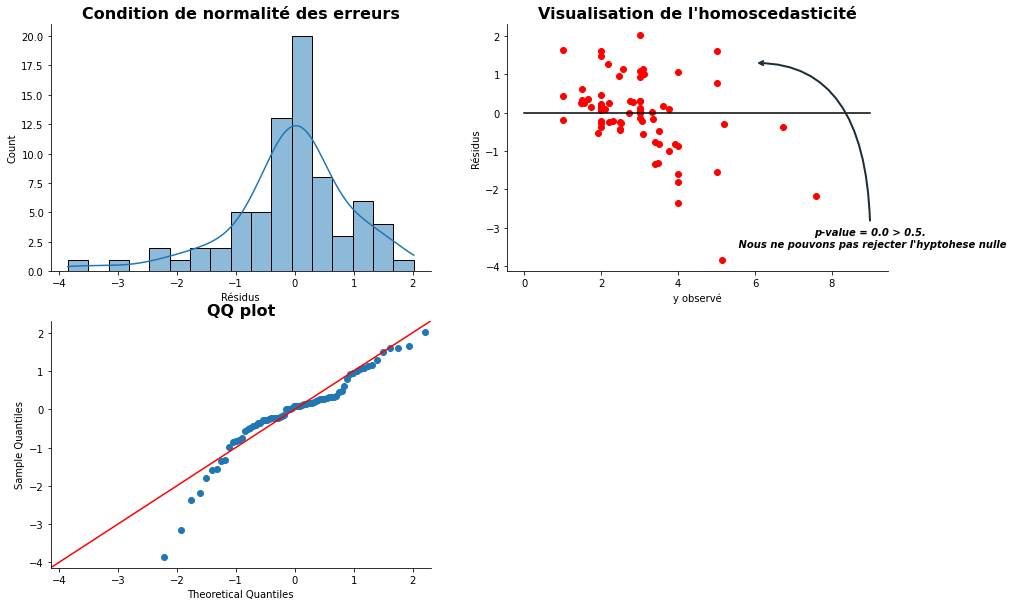

In [30]:
import statsmodels.api as sm
fig, ((ax1,ax2),
      (ax3,ax4)) = plt.subplots(figsize=(15, 10),nrows=2, ncols=2)

ax1.set_title('Condition de normalité des erreurs', set_title())
sns.histplot(residus, ax = ax1, kde = True)
ax1.set_xlabel('Résidus')
remove_spine(ax1)

ax2.set_title("Visualisation de l'homoscedasticité", set_title())
ax2.scatter(y_test_3, residus, c="red")
ax2.plot(np.array(range(0,10)),np.zeros(10), c="black")
ax2.set_xlabel('y observé')
ax2.set_ylabel('Résidus')
remove_spine(ax2)

sentence = test_homo()
ax2.annotate(sentence,ha='center',fontsize=10,fontstyle='italic', xy=(6, 1.3),
             xytext=(9, -3.5),color='black',fontweight="extra bold", bbox=dict(color="white"),
            arrowprops=dict(color="#1d2d35",linewidth="2",arrowstyle="->", connectionstyle="angle3")
            )

ax3.set_title('QQ plot', set_title())
sm.qqplot(residus, line='45', ax= ax3)
remove_spine(ax3)

ax4.set_visible(False)

plt.show();